In [1]:
from functions import intodf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.metrics import roc_curve, auc, log_loss


Light GBM
1. First testing parameters using CV with **original data (8columns)**

Data cleaning: defining df1,2,3 for image1,2,3

In [2]:
df3 = intodf('O013257.npz') #image3 - test
df2 = intodf('O013490.npz') #image2 - train
df1 = intodf('O012791.npz') #image1 - train

# Drop label=0 since they are of no use.
df1 = df1[df1['label'] != 0]
df2 = df2[df2['label'] != 0]
df3 = df3[df3['label'] != 0]

In [3]:
# Define features and labels for each
X_df1 = df1.drop(columns=["X", "Y", "label"])
y_df1 = df1["label"]
X_df2 = df2.drop(columns=["X", "Y", "label"])
y_df2 = df2["label"]
X_test = df3.drop(columns=["X", "Y", "label"])
y_test = df3["label"]

# Full training set for final retraining
df_train = pd.concat([df1, df2])
X_train_full = df_train.drop(columns=["X", "Y", "label"])
y_train_full = df_train["label"]

In [4]:
#Light GBM
# Hyperparameter grid
param_grid = {
    'num_leaves': [7, 15, 31],
    'learning_rate': [0.01, 0.05, 0.1, 0.15]
}

# Base parameters
base_params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'feature_fraction': 0.7,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_bin': 127,
    'verbose': -1  # Silence all LightGBM output
}

###### 2-Fold CV setup #######
folds = [(X_df1, y_df1, X_df2, y_df2), (X_df2, y_df2, X_df1, y_df1)]

# Hyperparameter tuning
best_params = None
best_avg_val_error = float('inf')

## Grid search for the 9 combinations of hyperparameters
for num_leaves in param_grid['num_leaves']:
    for learning_rate in param_grid['learning_rate']:
        params = base_params.copy()
        params['num_leaves'] = num_leaves
        params['learning_rate'] = learning_rate
        
        val_errors = []
        print(f"Testing: num_leaves={num_leaves}, learning_rate={learning_rate}")
        
        for X_train, y_train, X_valid, y_valid in folds: ## for each fold train with one df, validate with another
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)
            
            model = lgb.train(
                params,
                train_data,
                num_boost_round=500,
                valid_sets=[valid_data],
                valid_names=['valid'],
                callbacks=[lgb.early_stopping(20, verbose=False)]  
            )
            val_error = model.best_score['valid']['binary_error']
            val_errors.append(val_error)
        
        avg_val_error = np.mean(val_errors)
        print(f"Average Validation Error: {avg_val_error:.4f}") 
        
        if avg_val_error < best_avg_val_error:
            best_avg_val_error = avg_val_error
            best_params = params

print(f"\nBest Parameters: num_leaves={best_params['num_leaves']}, learning_rate={best_params['learning_rate']}")
print(f"Best Average Validation Error: {best_avg_val_error:.4f}")

# Retrain with best parameters!!!!
print("\nRetraining with best parameters...")
train_data_full = lgb.Dataset(X_train_full, label=y_train_full)
final_model_1 = lgb.train(
    best_params,
    train_data_full,
    num_boost_round=500  # Fixed rounds, no early stopping
)

# Test on df3 , the third picture!!!
y_pred_1 = final_model_1.predict(X_test)
y_pred_binary_1 = np.where(y_pred_1 > 0.5, 1, -1)
test_accuracy_model_1 = accuracy_score(y_test, y_pred_binary_1) #Please calculate accuracy similar to this
test_error_1 = 1 - test_accuracy_model_1
print(f"Test Error with only original features on df3: {test_error_1:.4f}")
print(f"Test Accuracy with only original features on df3: {test_accuracy_model_1:.4f}")

Testing: num_leaves=7, learning_rate=0.01
Average Validation Error: 0.3389
Testing: num_leaves=7, learning_rate=0.05
Average Validation Error: 0.1143
Testing: num_leaves=7, learning_rate=0.1
Average Validation Error: 0.1089
Testing: num_leaves=7, learning_rate=0.15
Average Validation Error: 0.1210
Testing: num_leaves=15, learning_rate=0.01
Average Validation Error: 0.3383
Testing: num_leaves=15, learning_rate=0.05
Average Validation Error: 0.1146
Testing: num_leaves=15, learning_rate=0.1
Average Validation Error: 0.1125
Testing: num_leaves=15, learning_rate=0.15
Average Validation Error: 0.1179
Testing: num_leaves=31, learning_rate=0.01
Average Validation Error: 0.3449
Testing: num_leaves=31, learning_rate=0.05
Average Validation Error: 0.1175
Testing: num_leaves=31, learning_rate=0.1
Average Validation Error: 0.1179
Testing: num_leaves=31, learning_rate=0.15
Average Validation Error: 0.1215

Best Parameters: num_leaves=7, learning_rate=0.1
Best Average Validation Error: 0.1089

Retrai

Feature importance for LightGBM

Feature Importances for final_model_1 (Original 8 Features):
SD: 578
RDF: 429
CORR: 373
RAN: 367
NDAI: 360
RCF: 358
RAF: 277
RBF: 258


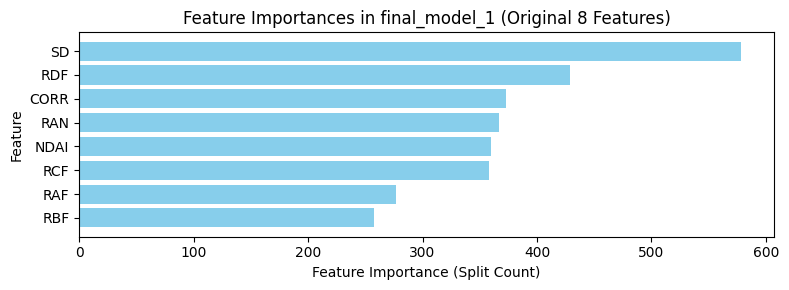

In [5]:
# Get feature importances
importances = final_model_1.feature_importance(importance_type='split')  # Split count
feature_names = X_test.columns

# Create a list of (feature, importance) tuples and sort by importance
feature_importance_pairs = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

# Print all features
print("Feature Importances for final_model_1 (Original 8 Features):")
for name, imp in feature_importance_pairs:
    print(f"{name}: {imp}")

# Plot all 8 features
features = [pair[0] for pair in feature_importance_pairs]
importances = [pair[1] for pair in feature_importance_pairs]

plt.figure(figsize=(8, 3))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Feature Importance (Split Count)')
plt.ylabel('Feature')
plt.title('Feature Importances in final_model_1 (Original 8 Features)')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()

2. Now testing lightGBM on df with **additional 32 ae_features**

In [6]:
# Load the three csv files from data_labeled
image_1 = pd.read_csv('../data/data_labeled/image1_ae.csv') 
image_2 = pd.read_csv('../data/data_labeled/image2_ae.csv')
image_3 = pd.read_csv('../data/data_labeled/image3_ae.csv')

In [7]:
#Rename the first two columns!!! convert from x,y to X,Y
image_1 = image_1.rename(columns={'y': 'Y', 'x': 'X'})
image_2 = image_2.rename(columns={'y': 'Y', 'x': 'X'})
image_3 = image_3.rename(columns={'y': 'Y', 'x': 'X'})

# Merge original feature with 32 additional features on X and Y coordinates
df1_new = pd.merge(df1, image_1, on=['X', 'Y'], how='inner')
df2_new = pd.merge(df2, image_2, on=['X', 'Y'], how='inner')
df3_new = pd.merge(df3, image_3, on=['X', 'Y'], how='inner')
#now each df has 43 columns. (8 original + 32 new ae features) 

In [8]:
# Prepare features and labels
X_df1 = df1_new.drop(columns=['X', 'Y', 'label'])  # 40 features
y_df1 = df1_new['label']
X_df2 = df2_new.drop(columns=['X', 'Y', 'label'])
y_df2 = df2_new['label']
X_test = df3_new.drop(columns=['X', 'Y', 'label'])
y_test = df3_new['label']

df_train = pd.concat([df1_new, df2_new])
X_train_full = df_train.drop(columns=['X', 'Y', 'label'])
y_train_full = df_train['label']

In [9]:
# Hyperparameter grid (adjusted for more features)
param_grid = {
    'num_leaves': [15, 31, 63],  # Increased due to 40 features
    'learning_rate': [0.01, 0.05, 0.1]
}

# Base parameters
base_params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'feature_fraction': 0.7,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_bin': 127,
    'verbose': -1
}

# 2-Fold CV setup
folds = [(X_df1, y_df1, X_df2, y_df2), (X_df2, y_df2, X_df1, y_df1)]

# Hyperparameter tuning
best_params = None
best_avg_val_error = float('inf')

for num_leaves in param_grid['num_leaves']:
    for learning_rate in param_grid['learning_rate']:
        params = base_params.copy()
        params['num_leaves'] = num_leaves
        params['learning_rate'] = learning_rate
        
        val_errors = []
        print(f"Testing: num_leaves={num_leaves}, learning_rate={learning_rate}")
        
        for X_train, y_train, X_valid, y_valid in folds:
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)
            
            model = lgb.train(
                params,
                train_data,
                num_boost_round=500,
                valid_sets=[valid_data],
                valid_names=['valid'],
                callbacks=[lgb.early_stopping(20, verbose=False)]
            )
            val_error = model.best_score['valid']['binary_error']
            val_errors.append(val_error)
        
        avg_val_error = np.mean(val_errors)
        print(f"Average Validation Error: {avg_val_error:.4f}")
        
        if avg_val_error < best_avg_val_error:
            best_avg_val_error = avg_val_error
            best_params = params

# Final output
print(f"\nBest Parameters: num_leaves={best_params['num_leaves']}, learning_rate={best_params['learning_rate']}")
print(f"Best Average Validation Error: {best_avg_val_error:.4f}")

# Retrain with best parameters
print("\nRetraining with best parameters...")
train_data_full = lgb.Dataset(X_train_full, label=y_train_full)
final_model_2 = lgb.train(
    best_params,
    train_data_full,
    num_boost_round=500
)

# Test on df3
y_pred_2 = final_model_2.predict(X_test)
y_pred_binary_2 = np.where(y_pred_2 > 0.5, 1, -1)
test_accuracy_model_2 = accuracy_score(y_test, y_pred_binary_2) 
test_error_2= 1 - test_accuracy_model_2
print(f"Test Error with 40 features df3: {test_error_2:.4f}")
print(f"Test Accuracy with 40 features df3: {test_accuracy_model_2:.4f}")

Testing: num_leaves=15, learning_rate=0.01
Average Validation Error: 0.3657
Testing: num_leaves=15, learning_rate=0.05
Average Validation Error: 0.1461
Testing: num_leaves=15, learning_rate=0.1
Average Validation Error: 0.1410
Testing: num_leaves=31, learning_rate=0.01
Average Validation Error: 0.1456
Testing: num_leaves=31, learning_rate=0.05
Average Validation Error: 0.1408
Testing: num_leaves=31, learning_rate=0.1
Average Validation Error: 0.1415
Testing: num_leaves=63, learning_rate=0.01
Average Validation Error: 0.1486
Testing: num_leaves=63, learning_rate=0.05
Average Validation Error: 0.1498
Testing: num_leaves=63, learning_rate=0.1
Average Validation Error: 0.1477

Best Parameters: num_leaves=31, learning_rate=0.05
Best Average Validation Error: 0.1408

Retraining with best parameters...
Test Error with 40 features df3: 0.0758
Test Accuracy with 40 features df3: 0.9242


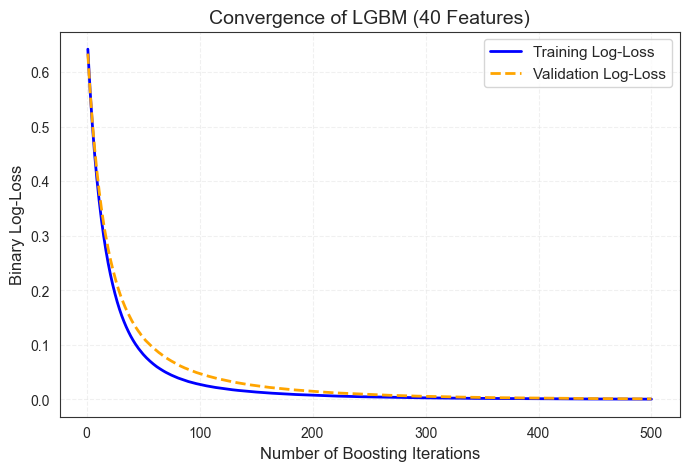

In [10]:
sns.set_style("whitegrid", {'axes.grid': True, 'grid.color': '0.9', 'axes.edgecolor': '0.2'})
train_data_full = lgb.Dataset(X_train_full, label=y_train_full)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data_full)

# Update best_params to use binary_logloss
best_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',  # Changed to binary_logloss
    'num_leaves': 31,  
    'learning_rate': 0.05,  
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Train the model with evaluation logging
evals_result = {}  # To store evaluation results
final_model_2 = lgb.train(
    best_params,
    train_data_full,
    num_boost_round=500,
    valid_sets=[train_data_full, valid_data],
    valid_names=['train', 'valid'],
    callbacks=[lgb.record_evaluation(evals_result)]
)

# Extract log-loss values
train_logloss = evals_result['train']['binary_logloss']
valid_logloss = evals_result['valid']['binary_logloss']
iterations = range(1, len(train_logloss) + 1)

# Create the plot
plt.figure(figsize=(8, 5))

# Plot Training Log-Loss
plt.plot(iterations, train_logloss, label='Training Log-Loss', 
         color='blue', linewidth=2)

# Plot Validation Log-Loss with a dashed line
plt.plot(iterations, valid_logloss, label='Validation Log-Loss', 
         color='orange', linewidth=2, linestyle='dashed')

# Labels and Title
plt.xlabel('Number of Boosting Iterations', fontsize=12)
plt.ylabel('Binary Log-Loss', fontsize=12)
plt.title('Convergence of LGBM (40 Features)', fontsize=14)

# Legend: Move outside for better readability
plt.legend(loc='upper right', fontsize=11, frameon=True)

# Subtle Grid
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('../figs/lgbm_convergence.png', bbox_inches='tight')

# Show the plot
plt.show()

Seems that the model with all the features (original + ae_features) seems better. 
Now we will draw confusion matrices for both models, to compare side by side.

Code for Confusion Matrix!!!

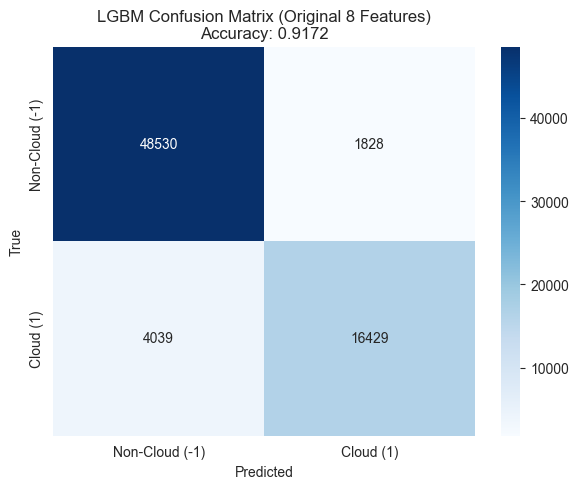

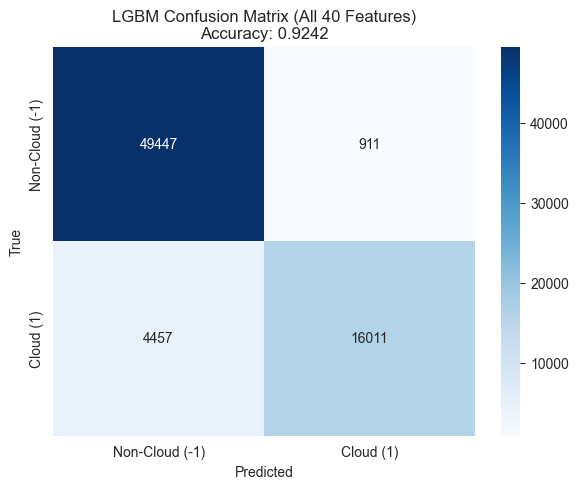

In [11]:
# Compute confusion matrices
cm_1 = confusion_matrix(y_test, y_pred_binary_1)
cm_2 = confusion_matrix(y_test, y_pred_binary_2)

# Compute accuracies (for reference)
acc_1 = accuracy_score(y_test, y_pred_binary_1)
acc_2 = accuracy_score(y_test, y_pred_binary_2)

# === Plot 1: Confusion Matrix for Original Features ===
plt.figure(figsize=(6, 5))
sns.heatmap(cm_1, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Cloud (-1)', 'Cloud (1)'],
            yticklabels=['Non-Cloud (-1)', 'Cloud (1)'])
plt.title(f'LGBM Confusion Matrix (Original 8 Features)\nAccuracy: {acc_1:.4f}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig('../figs/lgbm_cm1.png', bbox_inches='tight')
plt.show()

# === Plot 2: Confusion Matrix for All Features ===
plt.figure(figsize=(6, 5))
sns.heatmap(cm_2, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Cloud (-1)', 'Cloud (1)'],
            yticklabels=['Non-Cloud (-1)', 'Cloud (1)'])
plt.title(f'LGBM Confusion Matrix (All 40 Features)\nAccuracy: {acc_2:.4f}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig('../figs/lgbm_cm2.png', bbox_inches='tight')
plt.show()

It seems that the model with only the original 8 features is a little bit worse than the one with all 40 features, however model 1 is better in terms of True Positives (correctly classifying as clouds)

The model with 40 features improves accuracy by 0.7% (absolute), a modest but meaningful gain. This suggests the 32 autoencoded features add predictive power, though not dramatically.

- 40 Features Help: The autoencoded features improve overall accuracy (92.42% vs. 91.72%) by significantly reducing false positives (non-cloud misclassified as cloud). This is valuable if false positives are costly (e.g., over-predicting clouds in weather models).
- Trade-Off: The model sacrifices some recall for clouds (more false negatives), meaning it misses more cloud pixels. If missing clouds is critical (e.g., for safety in satellite imaging), this might be a concern.

In [12]:
# 1. Precision, Recall, F1 Score
# Compute for both models (for the positive class: Cloud, label=1)
precision_1, recall_1, f1_1, _ = precision_recall_fscore_support(y_test, y_pred_binary_1, average='binary', pos_label=1)
precision_2, recall_2, f1_2, _ = precision_recall_fscore_support(y_test, y_pred_binary_2, average='binary', pos_label=1)

print("Model 1 (final_model_1):")
print(f"Precision: {precision_1:.4f}, Recall: {recall_1:.4f}, F1 Score: {f1_1:.4f}")
print("Model 2 (final_model_2):")
print(f"Precision: {precision_2:.4f}, Recall: {recall_2:.4f}, F1 Score: {f1_2:.4f}")

Model 1 (final_model_1):
Precision: 0.8999, Recall: 0.8027, F1 Score: 0.8485
Model 2 (final_model_2):
Precision: 0.9462, Recall: 0.7822, F1 Score: 0.8564


In [13]:
# 2. Approximate AIC
# For LightGBM, we approximate AIC using log-loss (binary cross-entropy)
# AIC = 2k - 2*ln(L), where ln(L) is approximated via log-loss
# k = number of parameters (approximated as number of features + 1 for intercept-like term)

# Number of features
k_1 = 8   # final_model_1 (original 8 features)
k_2 = 40  # final_model_2 (8 original + 32 autoencoded)

# Compute log-loss (requires probability predictions)
logloss_1 = log_loss(y_test, y_pred_1, labels=[-1, 1])
logloss_2 = log_loss(y_test, y_pred_2, labels=[-1, 1])

# Approximate AIC: 2k + n * logloss (since logloss = -ln(L)/n, so -ln(L) = n * logloss)
n = len(y_test)
aic_1 = 2 * k_1 + n * logloss_1
aic_2 = 2 * k_2 + n * logloss_2

print("\nApproximate AIC:")
print(f"Model 1 (final_model_1): {aic_1:.2f}")
print(f"Model 2 (final_model_2): {aic_2:.2f}")


Approximate AIC:
Model 1 (final_model_1): 14048.86
Model 2 (final_model_2): 19438.33


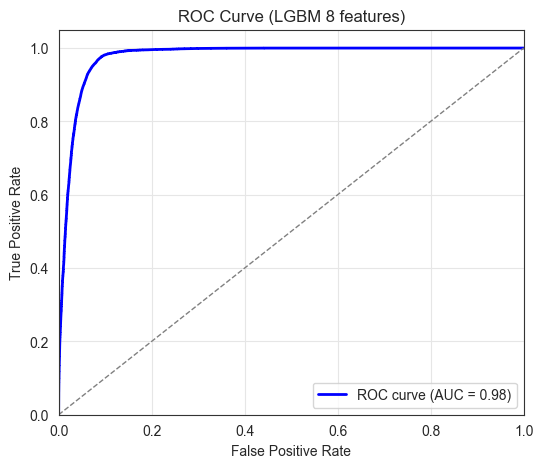

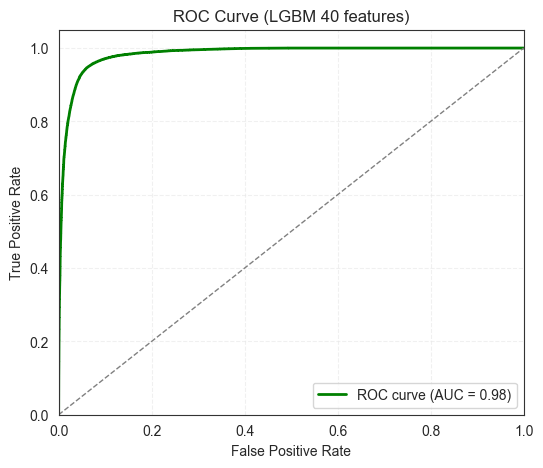

In [14]:
# 3. ROC Curve
# Compute ROC curves and AUC
fpr_1, tpr_1, _ = roc_curve(y_test, y_pred_1, pos_label=1)
roc_auc_1 = auc(fpr_1, tpr_1)

fpr_2, tpr_2, _ = roc_curve(y_test, y_pred_2, pos_label=1)
roc_auc_2 = auc(fpr_2, tpr_2)

# Model 1 ROC Curve (LGBM 8 features)
plt.figure(figsize=(6, 5))  # Individual figure for Model 1
plt.plot(fpr_1, tpr_1, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_1:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (LGBM 8 features)')
plt.legend(loc="lower right")
plt.show()

# Model 2 ROC Curve (LGBM 40 features)
plt.figure(figsize=(6, 5))  # Individual figure for Model 2
plt.plot(fpr_2, tpr_2, color='green', lw=2, label=f'ROC curve (AUC = {roc_auc_2:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (LGBM 40 features)')  # Fixed typo: "featrues" to "features"
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('../figs/lgbm_roc_all.png', bbox_inches='tight')
plt.show()

Top 20 Most Important Features:
ae27: 912
ae7: 775
ae0: 624
SD: 583
ae20: 575
ae21: 563
ae29: 530
ae9: 516
ae3: 511
ae11: 505
ae18: 480
ae22: 422
ae23: 416
ae25: 403
ae6: 402
ae30: 394
ae13: 376
ae16: 370
ae12: 361
ae4: 348


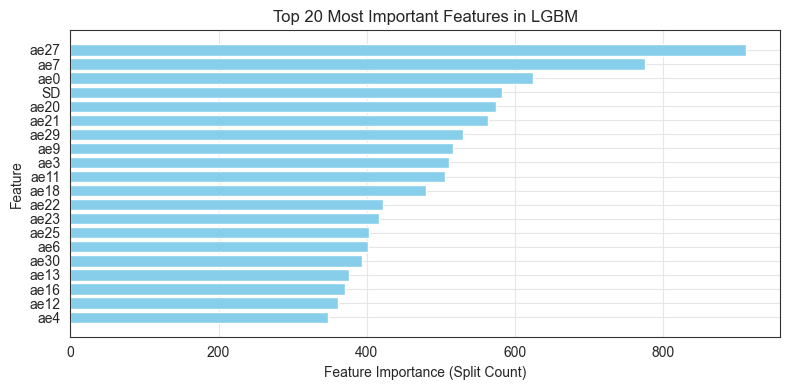

In [15]:
# Get feature importances
importances = final_model_2.feature_importance(importance_type='split')  # 'split' or 'gain'
feature_names = X_test.columns

# Create a list of (feature, importance) tuples
feature_importance_pairs = list(zip(feature_names, importances))

# Sort by importance in descending order
feature_importance_pairs = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

# Print top 20 features
print("Top 20 Most Important Features:")
for name, imp in feature_importance_pairs[:20]:
    print(f"{name}: {imp}")

# Plot top 10 features
top_20_features = [pair[0] for pair in feature_importance_pairs[:20]]
top_20_importances = [pair[1] for pair in feature_importance_pairs[:20]]

plt.figure(figsize=(8, 4))
plt.barh(top_20_features, top_20_importances, color='skyblue')
plt.xlabel('Feature Importance (Split Count)')
plt.ylabel('Feature')
plt.title('Top 20 Most Important Features in LGBM')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.savefig('../figs/lgbm_features.png', bbox_inches='tight')
plt.show()

The bar chart displays the top 10 most important features in final_model_all, which was trained on 40 features (8 original + 32 autoencoded) for cloud vs. non-cloud pixel classification task. The importance is measured by "split count," meaning how often each feature was used to split nodes across all trees in the LightGBM model. 

**Dominance of Autoencoded Features:**
Nine out of the top 10 features are autoencoded (ae27, ae7, ae20, etc.), indicating that the 32 autoencoded features are driving most of the model’s decision-making.
This aligns with confusion matrix results, where the 40-feature model improved accuracy (92.42% vs. 91.72%) over the 8-feature model. The autoencoded features are clearly adding predictive power.

In [16]:
df3_new['label'].value_counts()

label
-1.0    50358
 1.0    20468
Name: count, dtype: int64

Draw plots for post-hoc EDA!!!!

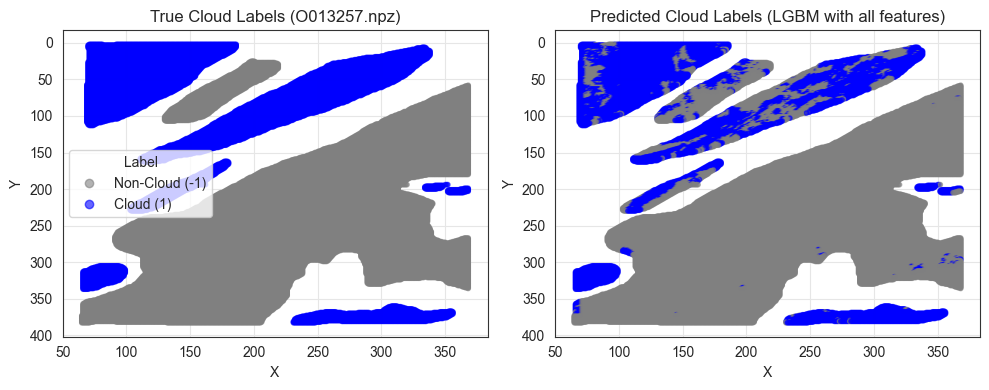

In [17]:
#plots for test picture
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Assuming df3_new and y_pred_binary_2 are already defined
# Create a dataframe with X, Y, true labels, and predicted labels
plot_df = pd.DataFrame({
    'X': df3_new['X'],
    'Y': df3_new['Y'],
    'True_Label': df3_new['label'],
    'Predicted_Label': y_pred_binary_2
})

# Define custom colormap: Non-Cloud (-1) -> grey, Cloud (1) -> blue
custom_cmap = ListedColormap(['grey', 'blue'])  # -1 (low) to 1 (high)

# 1. Scatter Plots (True vs. Predicted)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# True Labels
scatter1 = ax1.scatter(plot_df['X'], plot_df['Y'], c=plot_df['True_Label'], cmap=custom_cmap, s=10, alpha=0.6)
ax1.set_title('True Cloud Labels (O013257.npz)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.invert_yaxis()
# Legend
handles1, labels1 = scatter1.legend_elements()
ax1.legend(handles=handles1, labels=['Non-Cloud (-1)', 'Cloud (1)'], title="Label")

# Predicted Labels
scatter2 = ax2.scatter(plot_df['X'], plot_df['Y'], c=plot_df['Predicted_Label'], cmap=custom_cmap, s=10, alpha=0.6)
ax2.set_title('Predicted Cloud Labels (LGBM with all features)')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.invert_yaxis()
# Legend
handles2, labels2 = scatter2.legend_elements()

plt.tight_layout()
plt.savefig('../figs/postEDA_lgbm_1.png', bbox_inches='tight')
plt.show()

The scatter plots show that final_model_all accurately identifies non-cloud pixels (gray) but struggles with cloud pixels (blue). This is likely due to the imbalanced dataset, with more non-cloud pixels (71%) than cloud pixels (29%), causing the model to favor non-cloud predictions, as seen in the increased false negatives (cloud pixels misclassified as non-cloud) in the predicted plot.

Now we check the prediction plots and the actual plots for the pictures used in train. 

In [18]:
#plot for two train pictures

#first fit the y_predict_binary_2 for df1 and df2
y_pred_2_1 = final_model_2.predict(X_df1) 
y_pred_2_2 = final_model_2.predict(X_df2) 
y_pred_binary_2_1 = np.where(y_pred_2_1 > 0.5, 1, -1) #get predicted binary values for df1
y_pred_binary_2_2 = np.where(y_pred_2_2 > 0.5, 1, -1) #get predicted binary values for df2


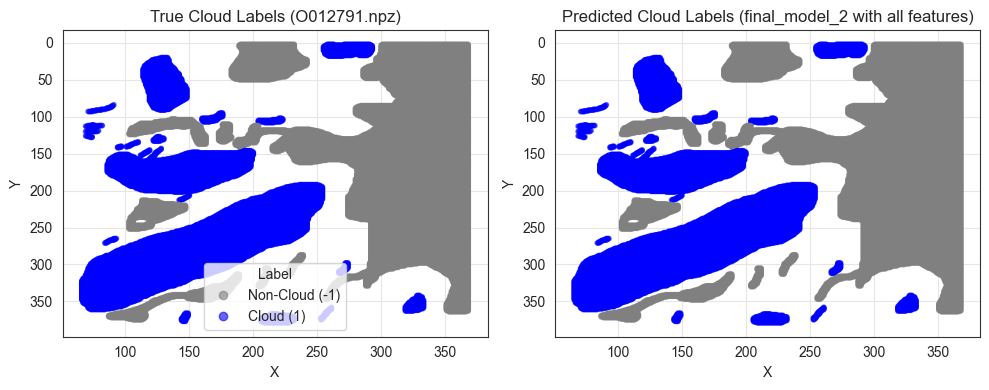

In [19]:
plot_df = pd.DataFrame({
    'X': df1_new['X'],
    'Y': df1_new['Y'],
    'True_Label': df1_new['label'],
    'Predicted_Label': y_pred_binary_2_1
})

# Define custom colormap: Non-Cloud (-1) -> grey, Cloud (1) -> blue
custom_cmap = ListedColormap(['grey', 'blue'])  # -1 (low) to 1 (high)

# 1. Scatter Plots (True vs. Predicted)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# True Labels
scatter1 = ax1.scatter(plot_df['X'], plot_df['Y'], c=plot_df['True_Label'], cmap=custom_cmap, s=10, alpha=0.6)
ax1.set_title('True Cloud Labels (O012791.npz)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.invert_yaxis()
# Legend
handles1, labels1 = scatter1.legend_elements()
ax1.legend(handles=handles1, labels=['Non-Cloud (-1)', 'Cloud (1)'], title="Label")

# Predicted Labels
scatter2 = ax2.scatter(plot_df['X'], plot_df['Y'], c=plot_df['Predicted_Label'], cmap=custom_cmap, s=10, alpha=0.6)
ax2.set_title('Predicted Cloud Labels (final_model_2 with all features)')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.invert_yaxis()
# Legend
handles2, labels2 = scatter2.legend_elements()

plt.tight_layout()
plt.savefig('../figs/postEDA_lgbm_2.png', bbox_inches='tight')
plt.show()

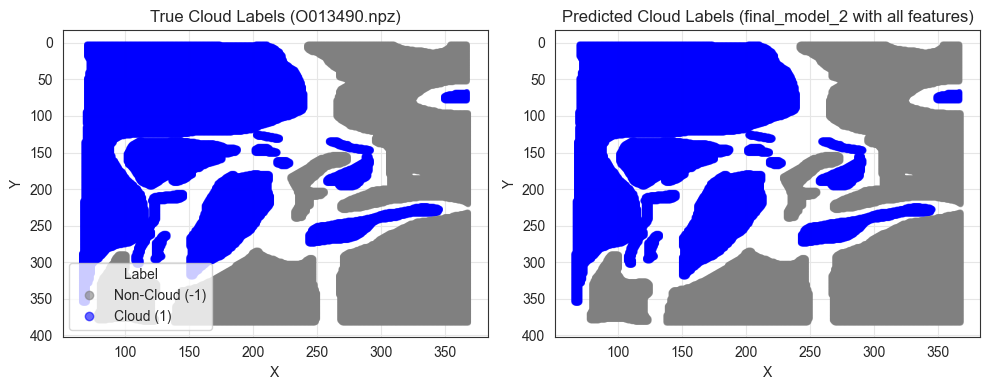

In [20]:
plot_df = pd.DataFrame({
    'X': df2_new['X'],
    'Y': df2_new['Y'],
    'True_Label': df2_new['label'],
    'Predicted_Label': y_pred_binary_2_2
})

# Define custom colormap: Non-Cloud (-1) -> grey, Cloud (1) -> blue
custom_cmap = ListedColormap(['grey', 'blue'])  # -1 (low) to 1 (high)

# 1. Scatter Plots (True vs. Predicted)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# True Labels
scatter1 = ax1.scatter(plot_df['X'], plot_df['Y'], c=plot_df['True_Label'], cmap=custom_cmap, s=10, alpha=0.6)
ax1.set_title('True Cloud Labels (O013490.npz)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.invert_yaxis()
# Legend
handles1, labels1 = scatter1.legend_elements()
ax1.legend(handles=handles1, labels=['Non-Cloud (-1)', 'Cloud (1)'], title="Label")

# Predicted Labels
scatter2 = ax2.scatter(plot_df['X'], plot_df['Y'], c=plot_df['Predicted_Label'], cmap=custom_cmap, s=10, alpha=0.6)
ax2.set_title('Predicted Cloud Labels (final_model_2 with all features)')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.invert_yaxis()
# Legend
handles2, labels2 = scatter2.legend_elements()

plt.tight_layout()
plt.savefig('../figs/postEDA_lgbm_3.png', bbox_inches='tight')
plt.show()

We can clearly see that the prediction for the train pictures are nearly perfect. 


### Misclassification plot

In [22]:
# Prepare df_test_analysis for misclassification analysis
df_test_analysis = df3_new.copy()  
df_test_analysis['predicted_label'] = y_pred_binary_2  

# Convert labels from {-1, 1} to {0, 1}
df_test_analysis['true_binary'] = np.where(df_test_analysis['label'] == -1, 0, 1)
df_test_analysis['pred_binary'] = np.where(df_test_analysis['predicted_label'] == -1, 0, 1)

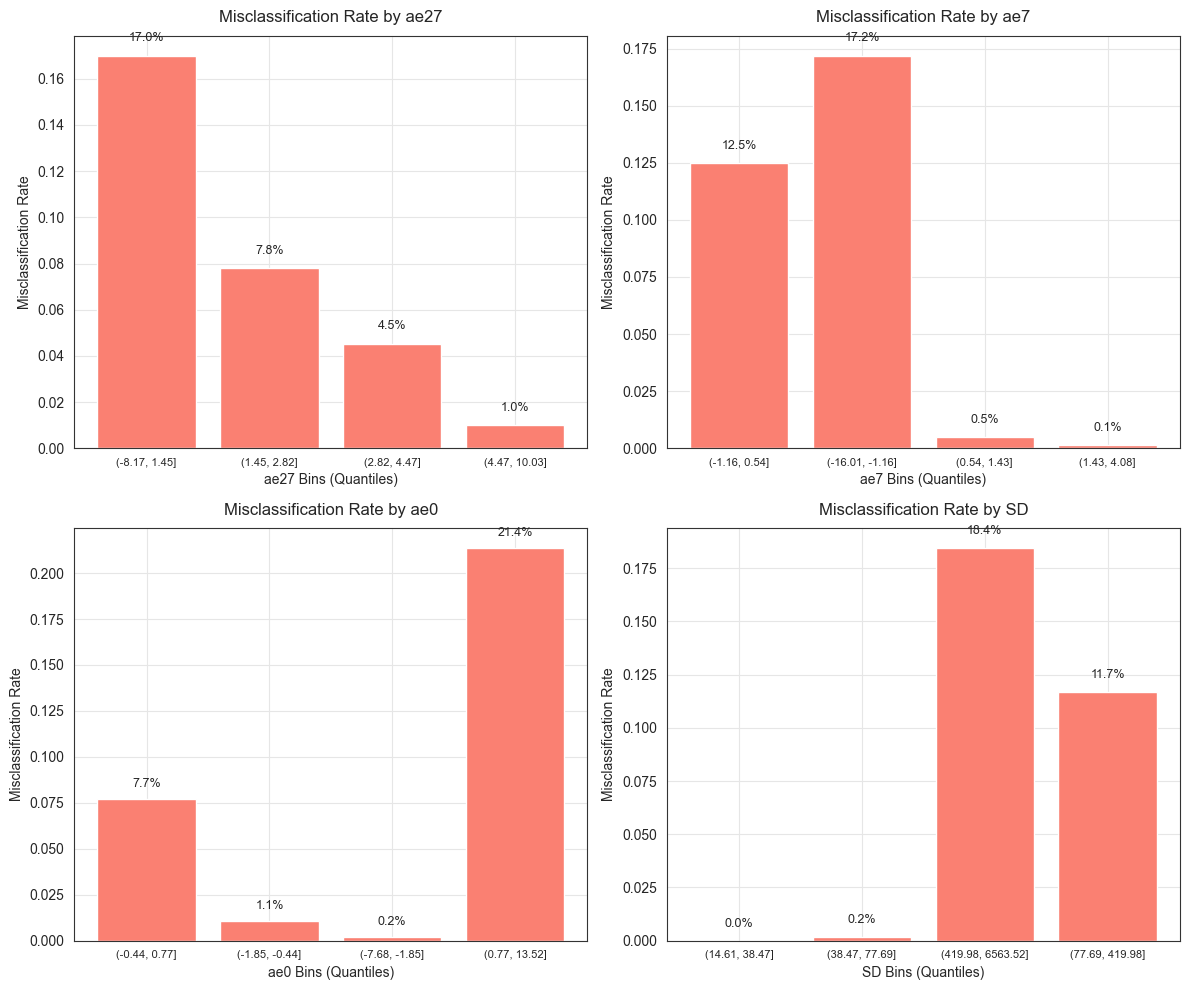

In [23]:

def plot_misclassification_by_bin(ax, df, feature_name, n_bins=4):
    """
    The function splits the data into n_bins quantiles based on feature_name,
    and calculates the misclassification rate in each bin. It plots a bar chart.
    """
    # Bins the feature into quantiles
    df['feature_bin'] = pd.qcut(df[feature_name], q=n_bins, duplicates='drop')

    # converting bin labels to formatted strings with consistent decimal places
    df['feature_bin'] = df['feature_bin'].astype(str).apply(lambda x: x.replace("(", "").replace("]", ""))  # Clean brackets
    df['feature_bin'] = df['feature_bin'].apply(lambda x: f"({float(x.split(',')[0]):.2f}, {float(x.split(',')[1]):.2f}]")

    # computes misclassification rate in each bin
    grouped = df.groupby('feature_bin').apply(lambda x: np.mean(x['true_binary'] != x['pred_binary']))
    grouped = grouped.reset_index(name='misclassification_rate')

    # Bar chart on provided subplot (ax)
    bars = ax.bar(range(len(grouped)), grouped['misclassification_rate'], color='salmon')

    # horizontal x-axis labels
    ax.set_xticks(range(len(grouped)))
    ax.set_xticklabels(grouped['feature_bin'], rotation=0, ha="center", fontsize=8)
    ax.set_xlabel(f"{feature_name} Bins (Quantiles)", fontsize=10)
    ax.set_ylabel("Misclassification Rate", fontsize=10)
    ax.set_title(f"Misclassification Rate by {feature_name}", fontsize=12, pad=10)

    # percentage labels on top of bars for increased readability
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.005, f"{height*100:.1f}%", 
                ha='center', va='bottom', fontsize=9)

#2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# feature names (top 4 important features)
features = ['ae27', 'ae7', 'ae0', 'SD']

# loops through each subplot
for ax, feature in zip(axes.flatten(), features):
    plot_misclassification_by_bin(ax, df_test_analysis, feature, n_bins=4)


plt.tight_layout()
plt.show()
